The dataset consists of proeotmics from 5 bones + brain + meninges
1. skull (calvaria)
2. forearm (humerus)
3. vertebra
4. pelvis
5. femur
6. brain
7. meninges (not in naive)

for 3 conditions,
1. naive
2. sham (surgical cut)
3. mcao (stroke model)

for 3 animals each.

total 60 groups.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import random 

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import anndata as ann

sc.settings.set_figure_params(dpi=100)


from utils import (
                    get_genes_per_group,                
                    filter_proteins_per_group, 
                    normalise,
                    impute_knn,
                    impute_knn_nan,
                    impute_min_value,
                    impute_min_value_nan,
                  )

from gprofiler import GProfiler
from gprofiler_plotting import plot_enrich, plot_gene_enrichment
from bioinfokit import analys, visuz
# from upsetplot import plot, from_contents


In [13]:
DATA_DIR = "/Users/mayar.ali/Documents/phd/projects/proteomics/skull_pipeline/data/scp/mouse/"

In [14]:
adata = sc.read(DATA_DIR + 'adata_preprocessed_individual.h5ad')

In [15]:
adata

AnnData object with n_obs × n_vars = 60 × 4172
    obs: 'condition', 'region', 'sample', 'condition_region', 'condition_region_sample'
    var: 'gene', 'protein_id', 'n_cells'

In [16]:
# set observations to lower case
adata.obs["region"] = [r.lower() for r in adata.obs["region"]]
adata.obs["region"] = adata.obs["region"].astype('category')

adata.obs["condition"] = [c.lower() for c in adata.obs["condition"]]
adata.obs["condition"] = adata.obs["condition"].astype('category')

adata.obs["condition_region"] = [c.lower() for c in adata.obs["condition_region"]]
adata.obs["condition_region"] = adata.obs["condition_region"].astype('category')

adata.obs["condition_region_sample"] = [c.lower() for c in adata.obs["condition_region_sample"]]
adata.obs["condition_region_sample"] = adata.obs["condition_region_sample"].astype('category')

# replacing sample 4 (meninges 3 replica) with 3
condition_region_sample = np.array([])
for c in adata.obs["condition_region_sample"]:
    if c.split('_')[-1] == "4":
        condition_region_sample = np.append(condition_region_sample, c[:-1] + "3")
    else:
        condition_region_sample = np.append(condition_region_sample, c)
        
adata.obs["condition_region_sample"] = condition_region_sample
adata.obs["condition_region_sample"] = adata.obs["condition_region_sample"].astype('category')     

#### Downstream analysis

         Falling back to preprocessing with `sc.pp.pca` and default params.


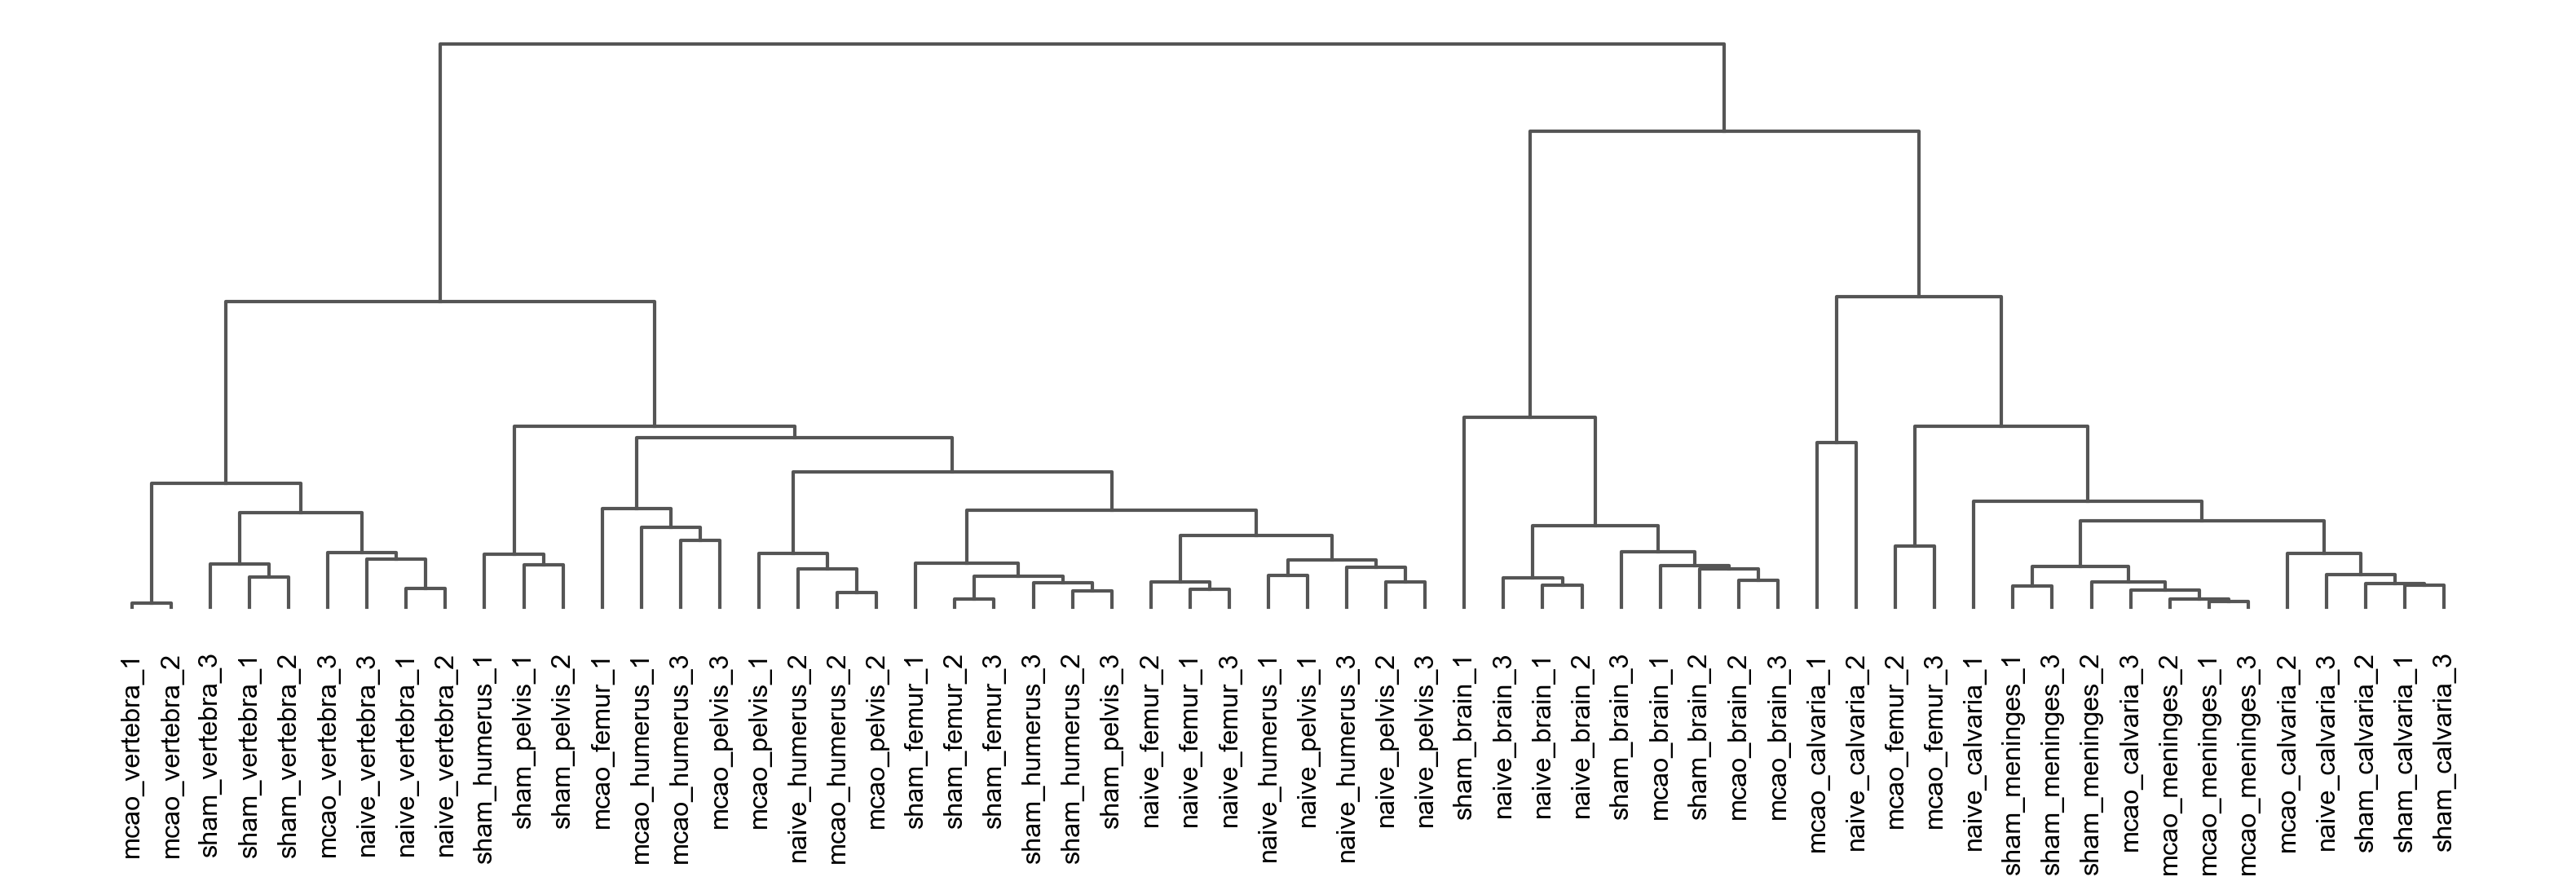

<AxesSubplot:>

In [17]:
plt.figure(figsize=(20, 5))
sc.tl.dendrogram(adata, groupby="condition_region_sample",)
sc.pl.dendrogram(adata, groupby="condition_region_sample", ax=plt.gca())

In [20]:
region_to_color = {
    "Calvaria"  : "#e377c2",
    "Brain"     : "#1f77b4",
    "Femur"     : "#ff7f0e",
    "Humerus"   : "#279e68",
    "Meninges"  : "#d62728",
    "Pelvis"    : "#aa40fc",
    "Scapula"   : "#8c564b",
    "Vertebra"  : "#b5bd61",
}

condition_to_color = {
    'MCAo'      : "#1f77b4",
    'Naive'     : "#ff7f0e",
    'Sham'      : "#279e68",
}

In [21]:
_color_brain = region_to_color["Brain"]
_color_calvaria = region_to_color["Calvaria"]
_color_femur = region_to_color["Femur"]
_color_humerus = region_to_color["Humerus"]
_color_meninges = region_to_color["Meninges"]
_color_pelvis = region_to_color["Pelvis"]
_color_vertebra = region_to_color["Vertebra"]

In [22]:
_color_naive = condition_to_color["Naive"]
_color_sham = condition_to_color["Sham"]
_color_mcao = condition_to_color["MCAo"]

In [23]:
adata.uns["condition_colors"] = [
    _color_mcao,
    _color_naive,
    _color_sham,
]

In [24]:
adata.uns["region_colors"] = [
    _color_brain,
    _color_calvaria,
    _color_femur,
    _color_humerus,
    _color_meninges,
    _color_pelvis,
    _color_vertebra,
]

In [25]:
adata_bones = adata[~adata.obs["region"].isin(["brain", "meninges"])]
adata_calvaria = adata[adata.obs["region"].isin(["calvaria"])]

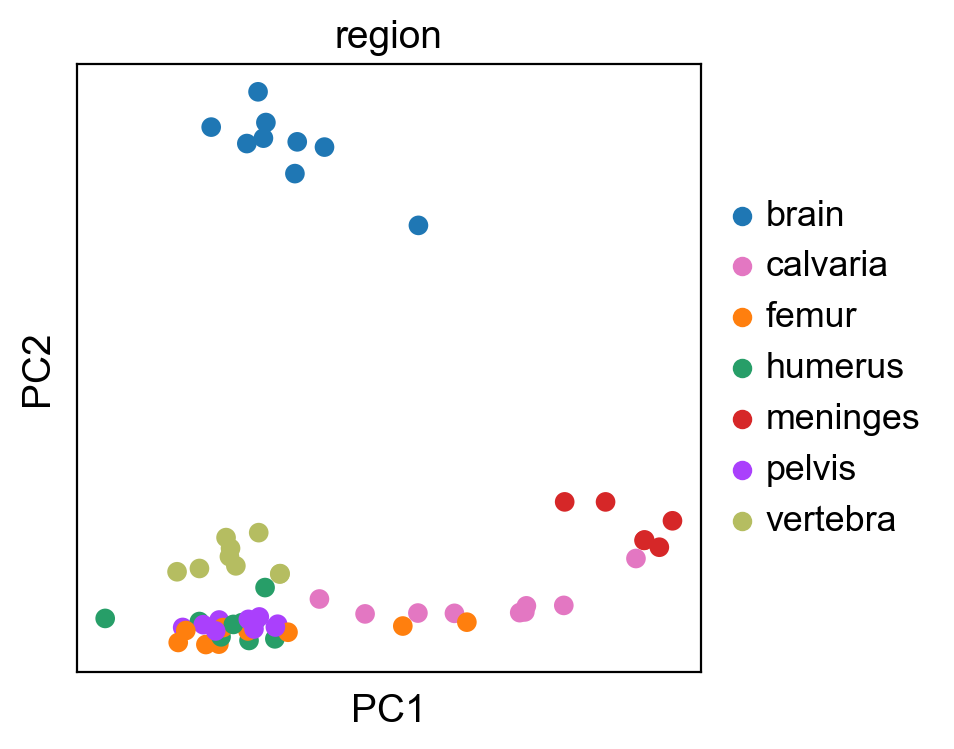

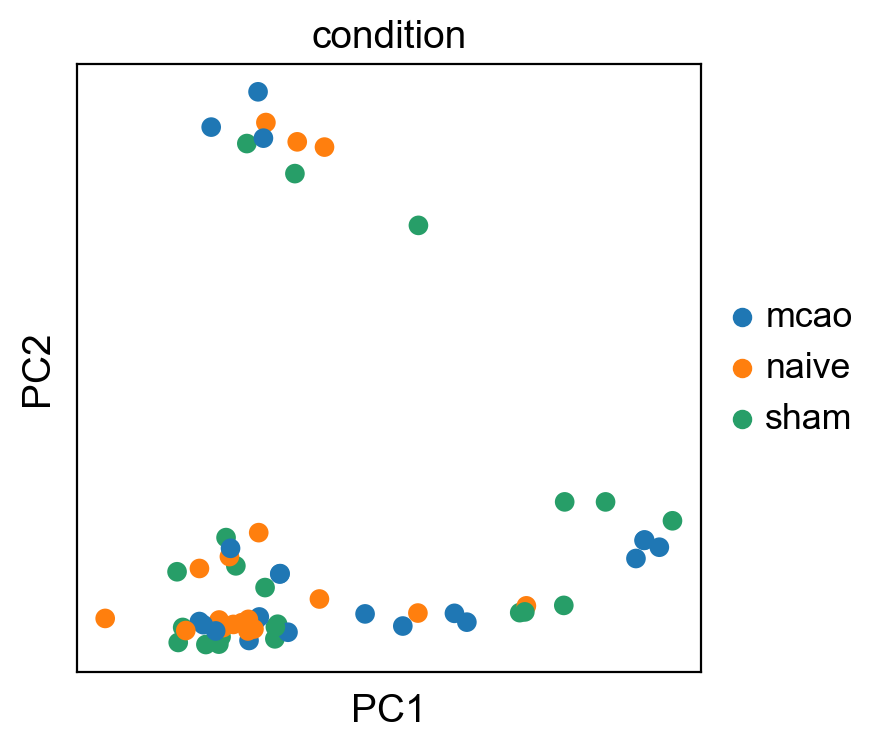

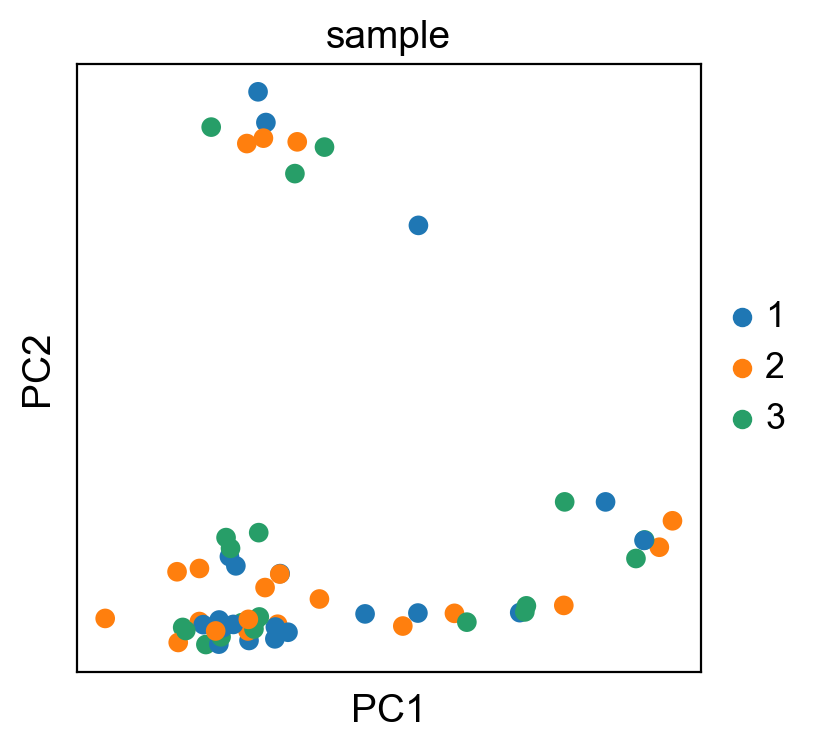

In [26]:
sc.tl.pca(adata)
sc.pl.pca(adata, color='region', size=200, save="_region_colors.pdf")
sc.pl.pca(adata, color='condition', size=200, save="_condition_colors.pdf")
sc.pl.pca(adata, color='sample', size=200, save="_samples_colors.pdf")

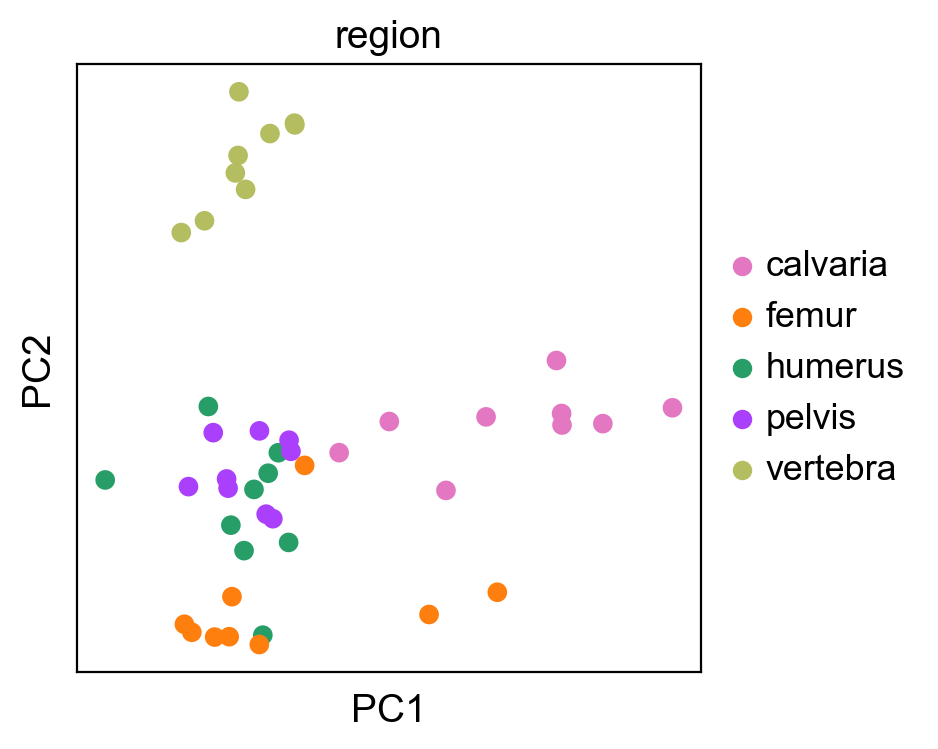

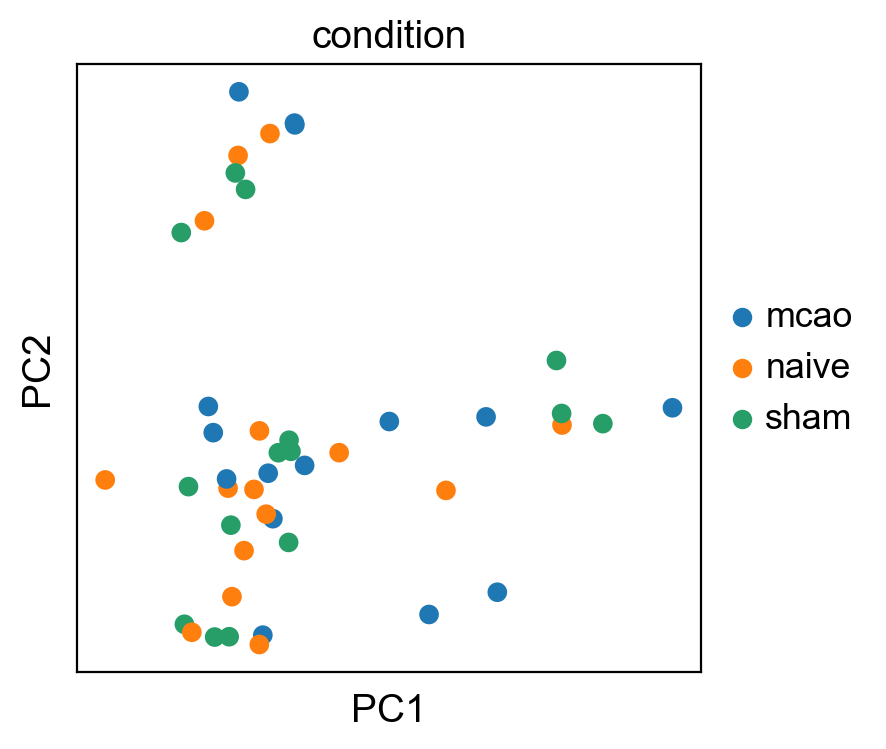

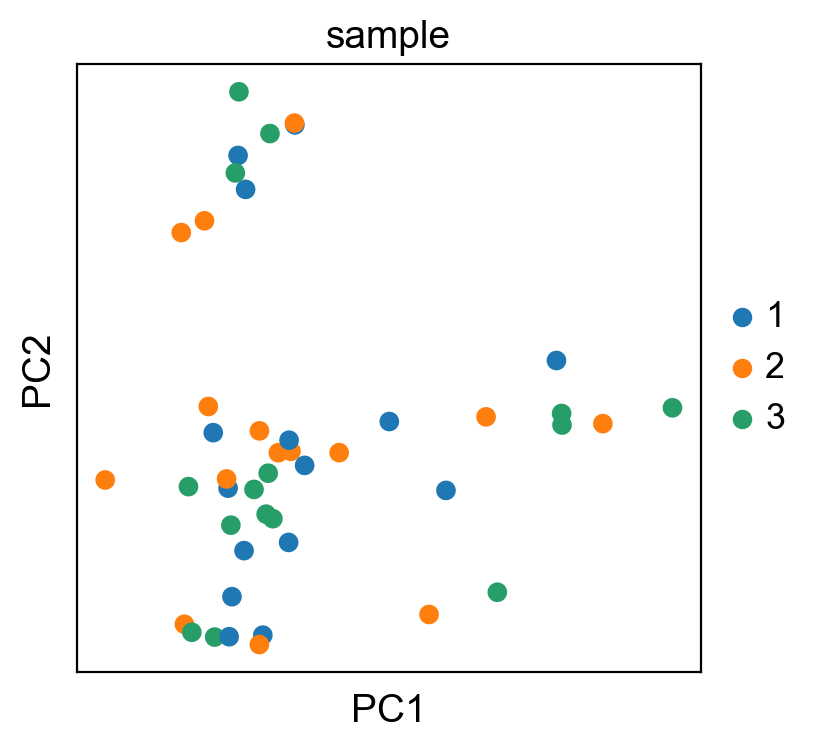

In [27]:
sc.tl.pca(adata_bones)
sc.pl.pca(adata_bones, color='region', size=200, save="_region_bones_color.pdf")
sc.pl.pca(adata_bones, color='condition', size=200, save="_condition_bones_color.pdf")
sc.pl.pca(adata_bones, color='sample', size=200)

In [28]:
adata.obs['condition_region_sample'] = adata.obs['condition'].astype(str) + '_' + \
                                           adata.obs['region'].astype(str) + '_' + \
                                            adata.obs['sample'].astype(str)
adata.obs['condition_region_sample'] = adata.obs['condition_region_sample'].astype('category')

In [29]:
adata_bones.obs['condition_region'] = adata_bones.obs['region'].astype(str) + ' ' + \
                                    adata_bones.obs['condition'].astype(str) 
                                           
adata_bones.obs['condition_region'] = adata_bones.obs['condition_region'].astype('category')

In [35]:
plt.rcParams.update({'font.size': 12})

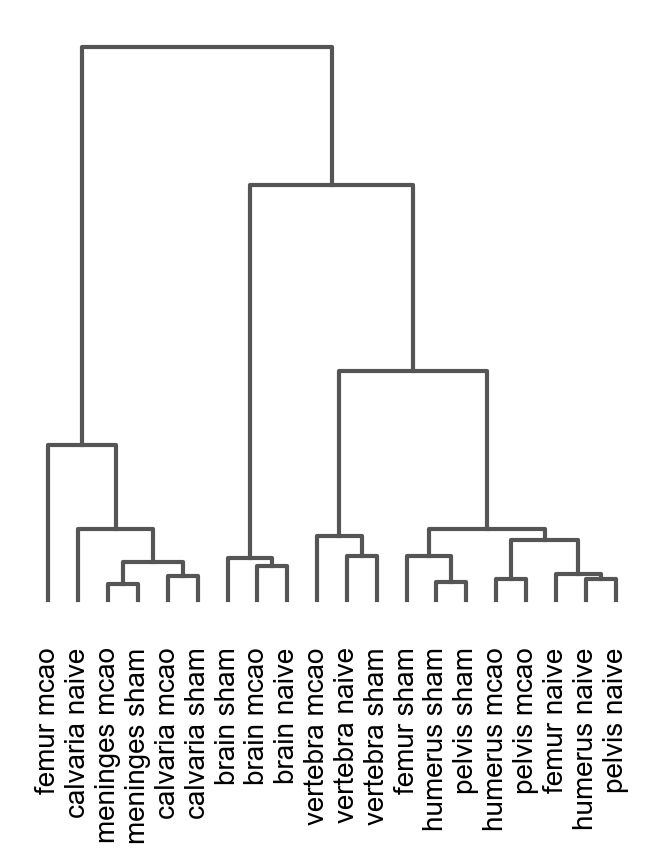

<AxesSubplot:>

In [36]:
sc.pl.dendrogram(adata, groupby="condition_region", save="_condition_region.pdf")

In [37]:
def rank_genes_groups_df(adata, group, pval_cutoff : float =None, logfc_cutoff=None): 
    d = pd.DataFrame() 
    for k in ['scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj']: 
        d[k] = adata.uns["rank_genes_groups"][k][group] 
    if pval_cutoff is not None: 
        d = d[d["pvals_adj"] < pval_cutoff] 
    if logfc_cutoff is not None: 
        d = d[d["logfoldchanges"].abs() > logfc_cutoff] 
    return d

def get_de_genes(adata, 
                 groupby, 
                 ref_group, 
                 n_genes, 
                 pval_threshold=0.05, 
                 logfoldchanges_threshold=0.5,
                 pval_col='pvals_adj'
                ):
    sc.tl.rank_genes_groups(adata, groupby=groupby, n_genes=n_genes)
    de_df = rank_genes_groups_df(adata, ref_group)
    de_df['diffexpressed'] = np.full(len(de_df), "NO")

    if logfoldchanges_threshold:
        de_df.loc[(de_df['logfoldchanges'] > logfoldchanges_threshold) & (de_df[pval_col] < pval_threshold), 'diffexpressed'] = 'UP'
        de_df.loc[(de_df['logfoldchanges'] < -logfoldchanges_threshold) & (de_df[pval_col] < pval_threshold), 'diffexpressed'] = 'DOWN'
    else:
        de_df.loc[(de_df[pval_col] < pval_threshold), 'diffexpressed'] = 'YES'
        return  de_df, de_df[de_df['diffexpressed'] == 'YES']["names"].values
    de_up = de_df[de_df['diffexpressed'] == 'UP']["names"].values
    de_down = de_df[de_df['diffexpressed'] == 'DOWN']["names"].values
    return de_df, de_up, de_down

In [38]:
# adapted from https://github.com/reneshbedre/bioinfokit/blob/master/bioinfokit/visuz.py

from matplotlib.colors import ListedColormap
def volcano(df="dataframe", lfc=None, pv=None, lfc_thr=(1, 1), pv_thr=(0.05, 0.05), color=("green", "grey", "red"),
                valpha=1, geneid=None, genenames=None, gfont=8, dim=(5, 5), r=300, ar=90, dotsize=8, markerdot="o",
                sign_line=False, gstyle=1, show=False, figtype='png', title=None, axtickfontsize=9,
                axtickfontname="Arial", axlabelfontsize=9, axlabelfontname="Arial", axxlabel=None,
                axylabel=None, xlm=None, ylm=None, plotlegend=False, legendpos='best',
                figname='volcano', legendanchor=None,
                legendlabels=['significant up', 'not significant', 'significant down'], save=None, theme=None):
        _x = r'$ log_{2}(Fold Change)$'
        _y = r'$ -log_{10}(P-value)$'
        color = color
        # check if dataframe contains any non-numeric character
        #assert general.check_for_nonnumeric(df[lfc]) == 0, 'dataframe contains non-numeric values in lfc column'
        #assert general.check_for_nonnumeric(df[pv]) == 0, 'dataframe contains non-numeric values in pv column'
        # this is important to check if color or logpv exists and drop them as if you run multiple times same command
        # it may update old instance of df
        df = df.drop(['color_add_axy', 'logpv_add_axy'], axis=1, errors='ignore')
        assert len(set(color)) == 3, 'unique color must be size of 3'
        df.loc[(df[lfc] >= lfc_thr[0]) & (df[pv] < pv_thr[0]), 'color_add_axy'] = color[0]  # upregulated
        df.loc[(df[lfc] <= -lfc_thr[1]) & (df[pv] < pv_thr[1]), 'color_add_axy'] = color[2]  # downregulated
        df['color_add_axy'].fillna(color[1], inplace=True)  # intermediate
        df['logpv_add_axy'] = -(np.log10(df[pv]))
        # plot
        assign_values = {col: i for i, col in enumerate(color)}
        color_result_num = [assign_values[i] for i in df['color_add_axy']]
        assert len(set(color_result_num)) == 3, \
            'either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include ' \
            'both significant and non-significant genes'
        if theme == 'dark':
            general.dark_bg()
        plt.subplots(figsize=dim)
        if plotlegend:
            s = plt.scatter(df[lfc], df['logpv_add_axy'], c=color_result_num, cmap=ListedColormap(color), alpha=valpha,
                            s=dotsize, marker=markerdot)
            assert len(legendlabels) == 3, 'legendlabels must be size of 3'
            plt.legend(handles=s.legend_elements()[0], labels=legendlabels, loc=legendpos, bbox_to_anchor=legendanchor)
        else:
            plt.scatter(df[lfc], df['logpv_add_axy'], c=color_result_num, cmap=ListedColormap(color), alpha=valpha,
                        s=dotsize, marker=markerdot)
        if sign_line:
            plt.axhline(y=-np.log10(pv_thr[0]), linestyle='--', color='#7d7d7d', linewidth=1)
            plt.axvline(x=lfc_thr[0], linestyle='--', color='#7d7d7d', linewidth=1)
            plt.axvline(x=-lfc_thr[1], linestyle='--', color='#7d7d7d', linewidth=1)
        if title:
            plt.title(title)
        if save:
            plt.savefig(save)
        if show:
            plt.show()

In [39]:
def plot_volcano(adata, 
                 groupby, 
                 ref_group, 
                 logfoldchanges_threshold=None, 
                 pval_col='pvals',
                 plot_volcano=True,
                 title='',
                 save_fig=None,
                 save_de_genes=None,
                 return_de=False,
                ):
    de_df, de_genes = get_de_genes(
        adata=adata, 
        groupby=groupby, 
        ref_group=ref_group,
        n_genes=adata.var_names.size,
        logfoldchanges_threshold=logfoldchanges_threshold,
        pval_col=pval_col
    )
    print(f'There are {len(np.unique(de_genes))} genes differentially expressed in {ref_group} vs rest.')
    print()
    de_df_sig = de_df[de_df["diffexpressed"] == "YES"]
    
    de_df_up = de_df_sig[de_df_sig["logfoldchanges"] > LOGFOLDCHANGE_THRESHOLD]
    de_df_down = de_df_sig[de_df_sig["logfoldchanges"] < -LOGFOLDCHANGE_THRESHOLD]
    print(f'There are {len(de_df_up)} genes differentially up regulated')
    print(f'There are {len(de_df_down)} genes differentially down regulated')
    
    
    # plot volcano
    if plot_volcano:
        fig = volcano(df=de_df, 
                 lfc='logfoldchanges', 
                 pv='pvals', 
                 show=True, 
                 dotsize=2,
                 geneid="names", 
#                  genenames=genenames,
                 lfc_thr=(LOGFOLDCHANGE_THRESHOLD, LOGFOLDCHANGE_THRESHOLD),
                 sign_line=True,
                 color=("#E10600FF", "grey", "#00239CFF"), 
                 plotlegend=True, 
                 axtickfontname='sans-serif',
                 axlabelfontname='sans-serif',
                 legendpos='upper right', 
                 legendanchor=(1.55,1.025),
                 title=title,
                 save=save_fig,
            )
        
    if save_de_genes:
        df = pd.DataFrame()
        df["genes"] = de_df_up["names"].tolist() + de_df_down["names"].tolist()
        df["diffexpressed"] = np.append(np.full(len(de_df_up["names"].tolist()), "UP"),
                                        np.full(len(de_df_down["names"].tolist()), "DOWN"))
        df.to_csv(save_de_genes)
    
    if return_de:
        return de_df_sig, de_df_down, de_df_up

In [40]:
LOGFOLDCHANGE_THRESHOLD=1
pvals_col = 'pvals'

In [41]:
from matplotlib_venn import venn2

Calvaria vs bones - naive


Trying to set attribute `.uns` of view, copying.


There are 1232 genes differentially expressed in calvaria vs rest.

There are 47 genes differentially up regulated
There are 1075 genes differentially down regulated


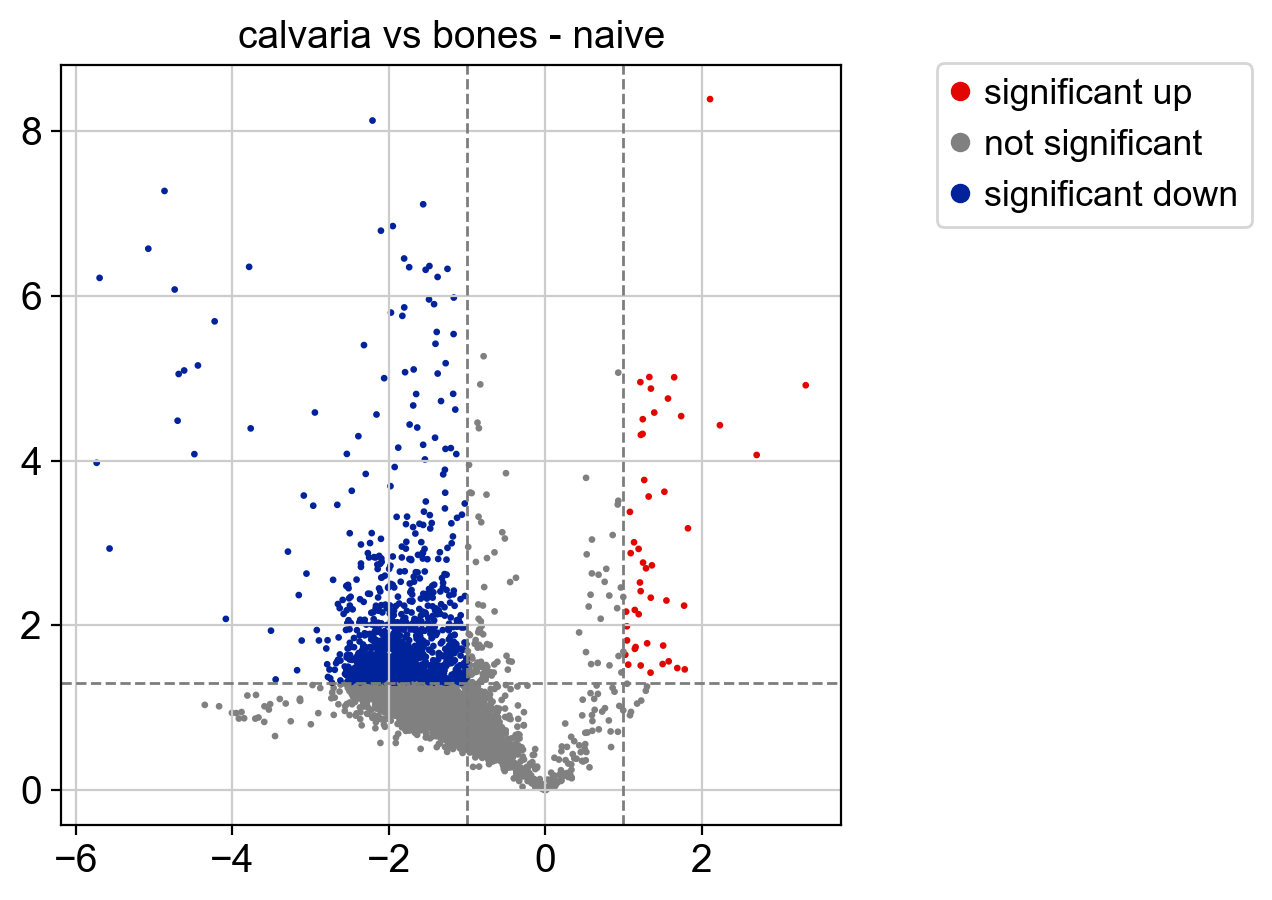

In [42]:
bone="calvaria"
condition="naive"
print('Calvaria vs bones - naive')
adata_naive_bones = adata_bones[adata_bones.obs["condition"] == "naive"]

groupby="region"
ref_group="calvaria"
de_df_sig, de_df_down, de_df_up = plot_volcano(
    adata=adata_naive_bones, 
    groupby=groupby, 
    ref_group=ref_group, 
    logfoldchanges_threshold=None, 
    pval_col=pvals_col,
    plot_volcano=True,
    title='calvaria vs bones - naive',
    return_de=True,
)

Calvaria vs bones - sham


Trying to set attribute `.uns` of view, copying.


There are 3790 genes differentially expressed in calvaria vs rest.

There are 67 genes differentially up regulated
There are 3640 genes differentially down regulated


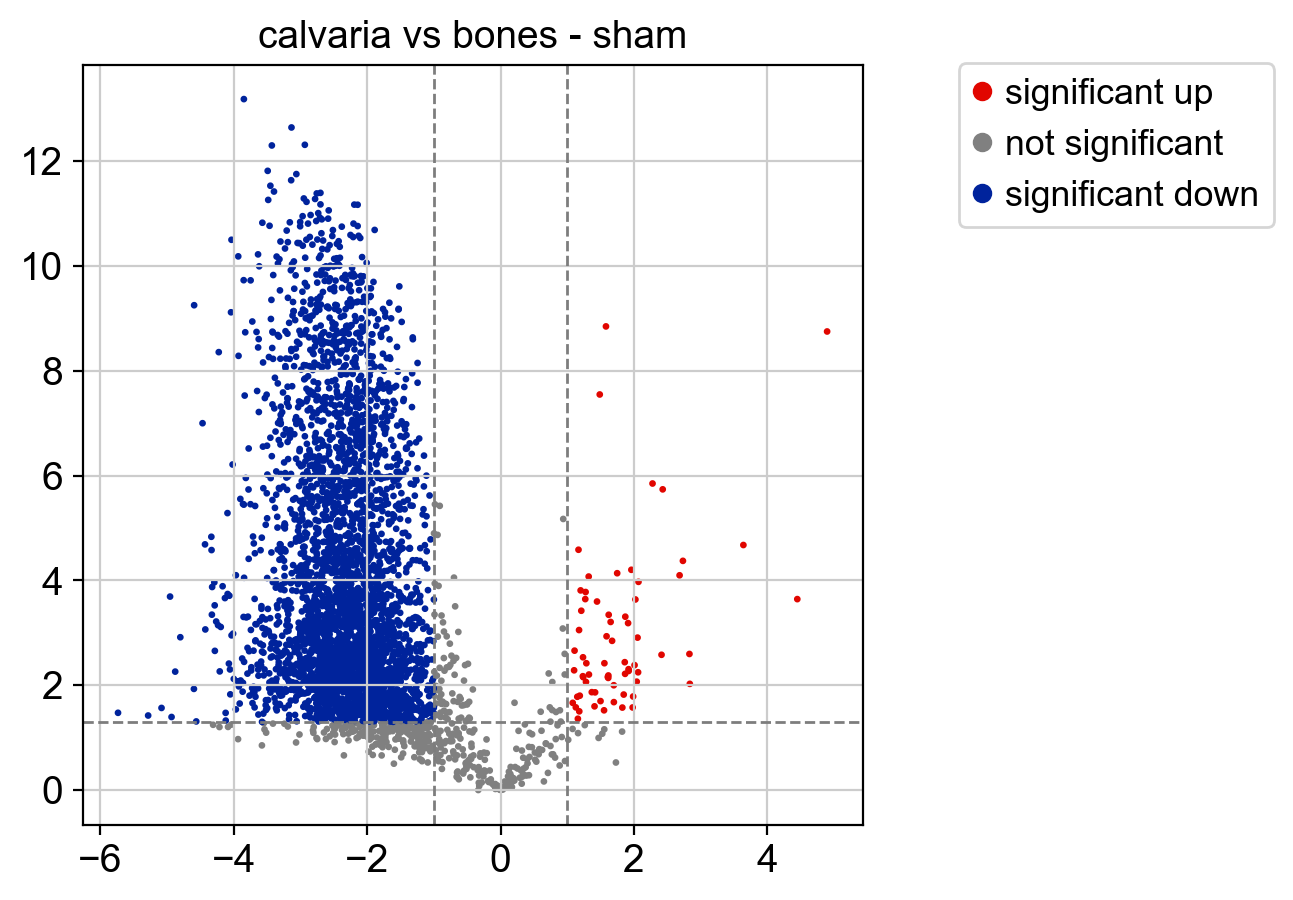

In [45]:
condition="sham"
print('Calvaria vs bones - sham')
adata_sham_bones = adata_bones[adata_bones.obs["condition"] == "sham"]


groupby="region"
ref_group="calvaria"
de_df_sig, de_df_down, de_df_up = plot_volcano(
    adata=adata_sham_bones, 
    groupby=groupby, 
    ref_group=ref_group, 
    logfoldchanges_threshold=None, 
    pval_col=pvals_col,
    plot_volcano=True,
    title='calvaria vs bones - sham',
    return_de=True,
)

Calvaria vs bones - mcao


Trying to set attribute `.uns` of view, copying.


There are 1036 genes differentially expressed in calvaria vs rest.

There are 69 genes differentially up regulated
There are 861 genes differentially down regulated


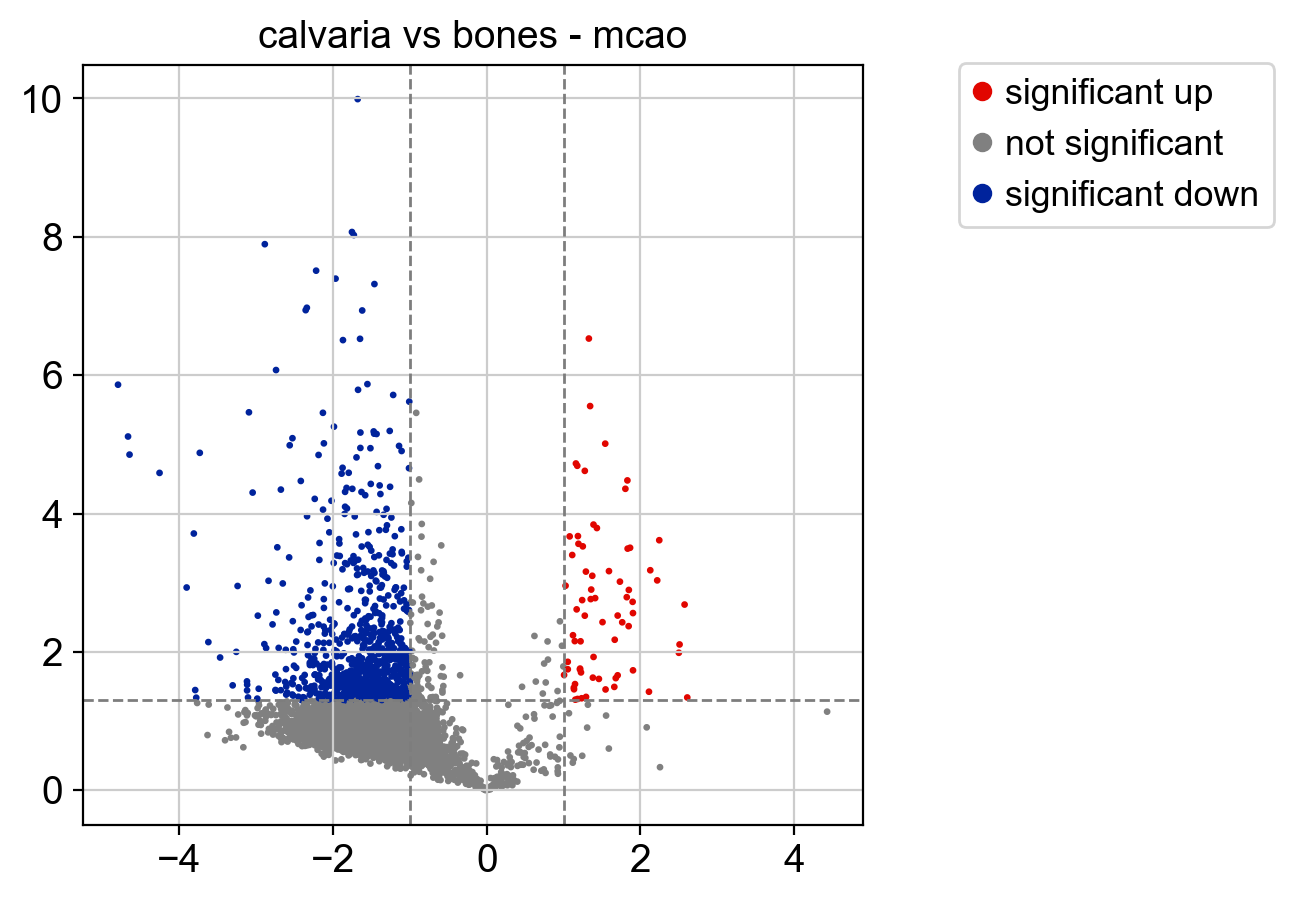

In [47]:
condition="mcao"
print('Calvaria vs bones - mcao')
adata_mcao_bones = adata_bones[adata_bones.obs["condition"] == "mcao"]


groupby="region"
ref_group="calvaria"
de_df_sig, de_df_down, de_df_up = plot_volcano(
    adata=adata_mcao_bones, 
    groupby=groupby, 
    ref_group=ref_group, 
    logfoldchanges_threshold=None, 
    pval_col=pvals_col,
    plot_volcano=True,
    title='calvaria vs bones - mcao',
    return_de=True,
)

Calvaria - MCAO vs Sham


Trying to set attribute `.uns` of view, copying.


There are 83 genes differentially expressed in mcao vs rest.

There are 51 genes differentially up regulated
There are 6 genes differentially down regulated


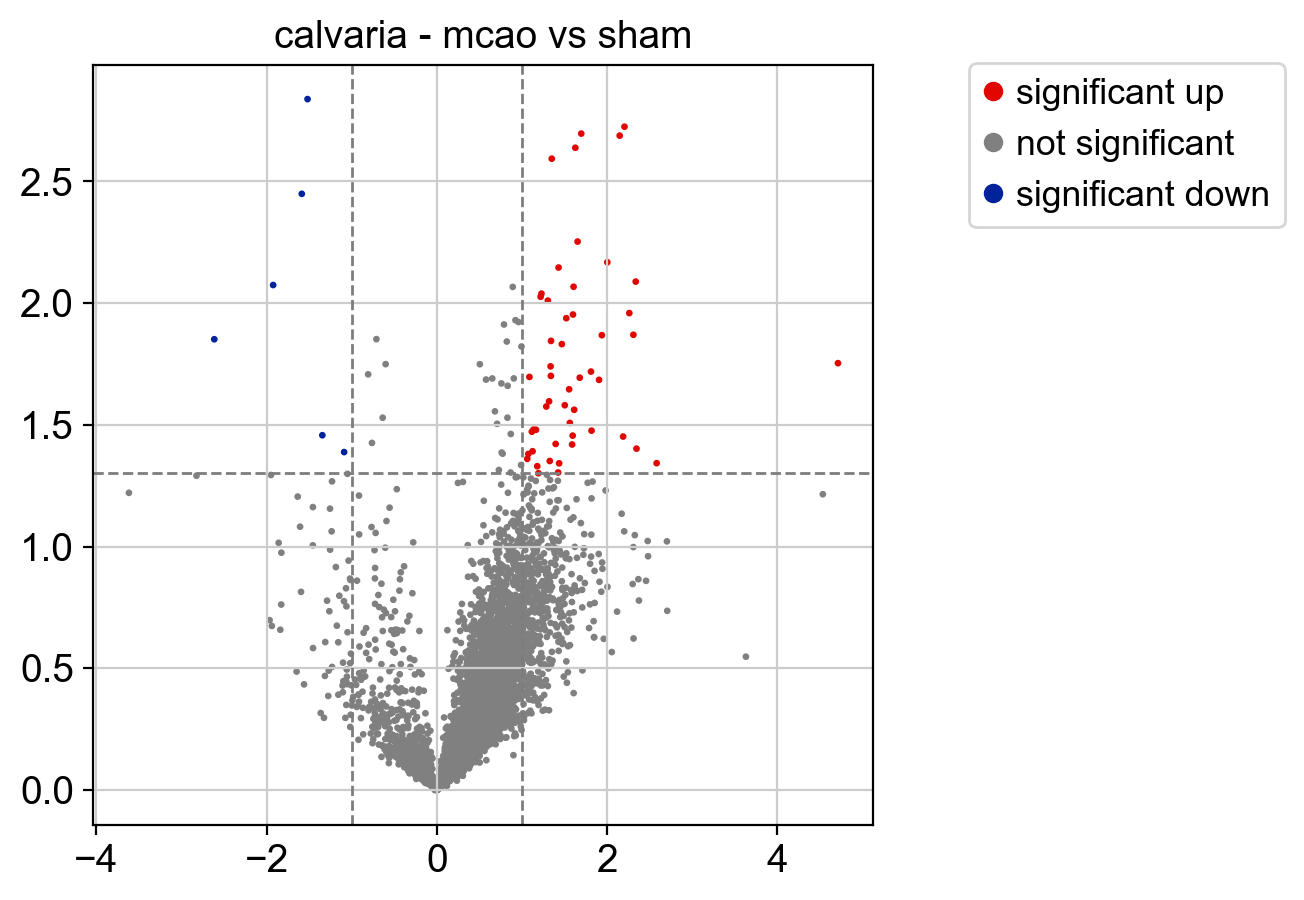

In [48]:
print('Calvaria - MCAO vs Sham')
adata_calvaria = adata[adata.obs["region"] == "calvaria"]
adata_calvaria = adata_calvaria[adata_calvaria.obs["condition"].isin(["sham", "mcao"])]

groupby="condition"
ref_group="mcao"
de_df_sig, de_df_down, de_df_up = plot_volcano(
    adata=adata_calvaria, 
    groupby=groupby, 
    ref_group=ref_group, 
    logfoldchanges_threshold=None, 
    pval_col=pvals_col,
    plot_volcano=True,
    title='calvaria - mcao vs sham',
    return_de=True,
)